# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


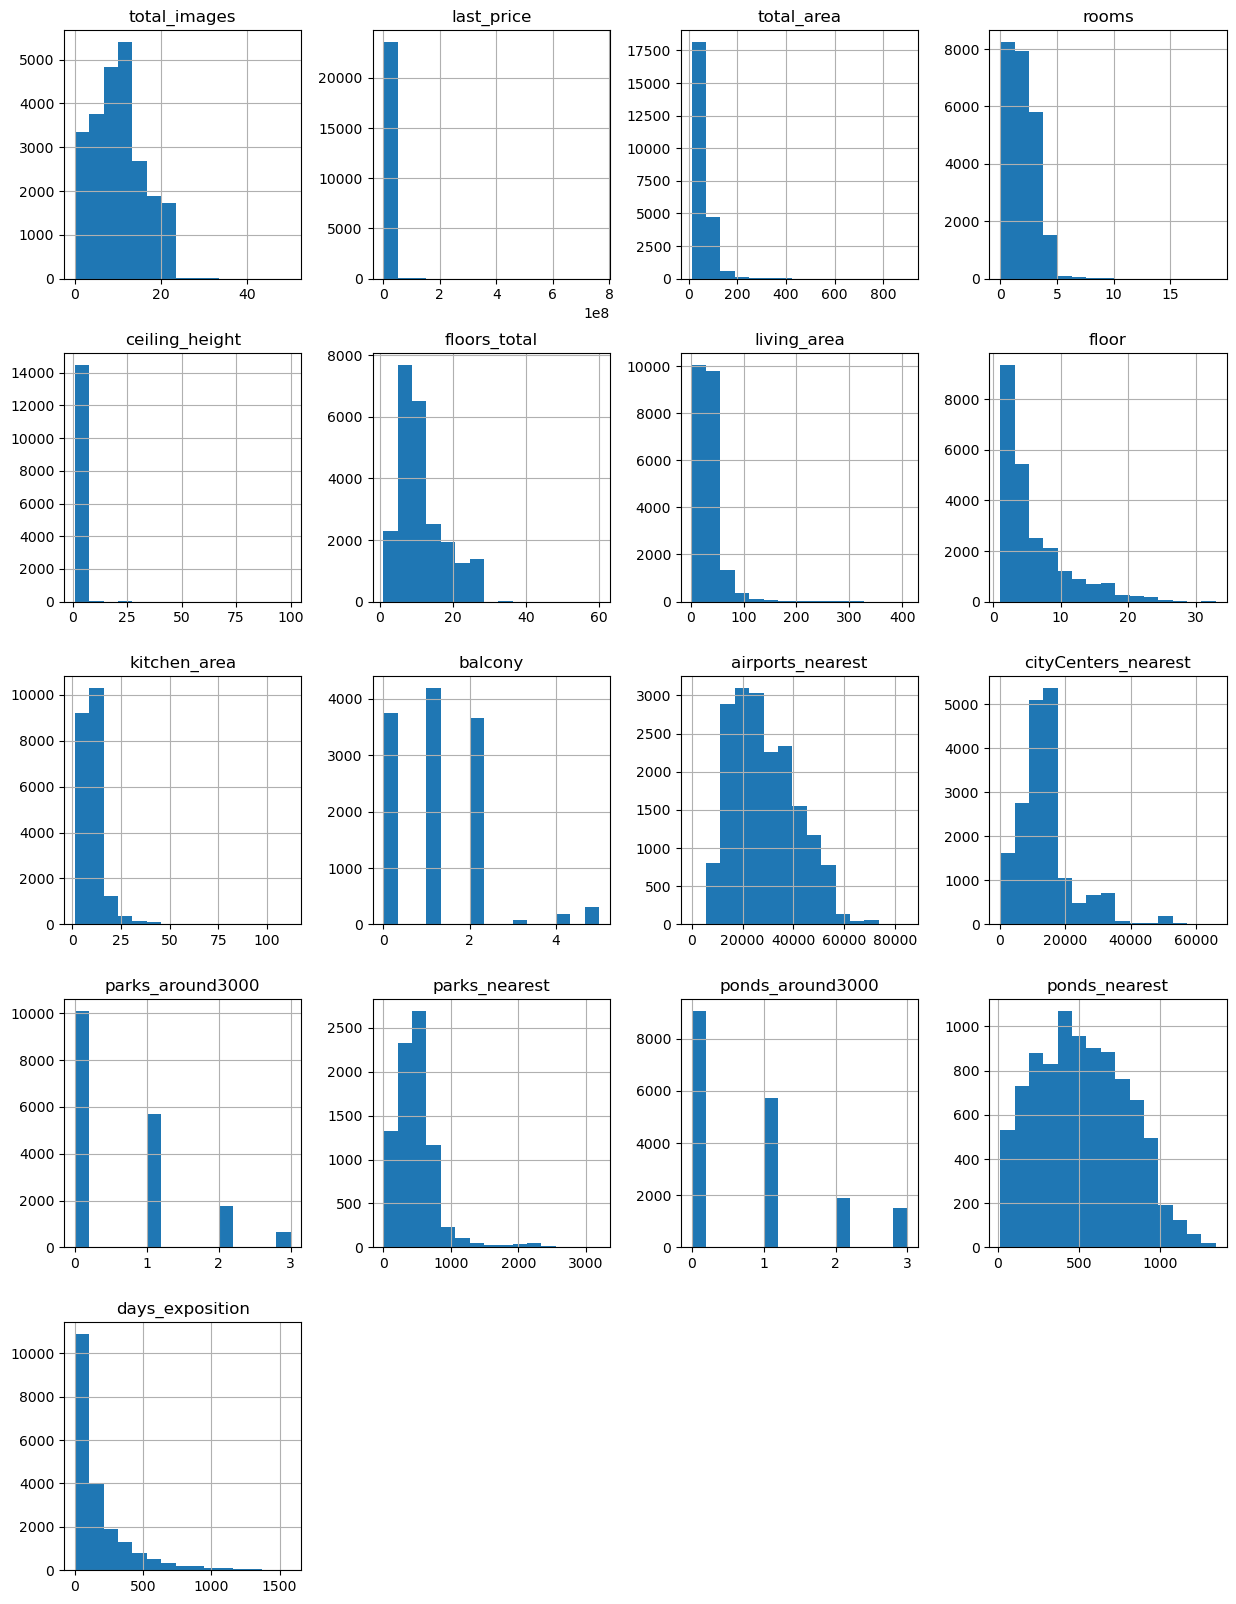

In [2]:
pd.set_option('display.max_columns', None)
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

df.hist(bins=15, figsize=(15, 20))
df.head(5)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В столбцах достаточно большое количество пропусков, неверные типы данных. Например в is_apartment слишком малое количество значений, в first_day_exposition неверных тип данных. Посчитаем пропуски изучем столбцы на аномалии:

### Предобработка данных

In [4]:
df.isnull().sum() #проверим количество пропусков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [5]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Выводы:
1. ceiling_height - большое количество пропусков. Аномалии: высокие потолки (100м) и низкие потолки (1м).
2. floors_total - небольшое количество пропусков относительно всего датафрейма (23699 строк), можно удалить. Перевести значения к типу 'int' (не мочет быть части этажа). Видим аномальное максимальное количество этажей = 60. Видимо квартира находится в Лахта-центр.
3. living_area - большое количество пропусков. Видим минимальную жилую площадь равную 2 м2. Такого не может быть, если, конечно, объявление размещал не гном.
4. is_apartment - огромное количество пропусков. Переведем в bool.
5. kitchen_area - большое количество пропусков.
6. balcony - большое количество пропусков. Заменить тип данных на 'int' (не может ыбть части балкона).
7. locality_name - небольшое количество пропусков.
8. airports_nearest - большое количество пропусков.
9. cityCenters_nearest - большое количество пропусков.
10. parks_around3000 - большое количество пропусков.
11. parks_nearest - огромное количество пропусков.
12. ponds_around3000 - большое количество пропусков.
13. ponds_nearest - огромное количество пропусков.
14. days_exposition - большое количество пропусков. Заменить тип данных на 'int'.
15. first_day_exposition - переведем в тип datetime.
16. total_area - огромные значения площадей.

In [6]:
#1. ceiling_height - заполним медианным значением. 2.65 - идеальное значение, если верить Яндексу ;)
df['ceiling_height'] = df['ceiling_height'].fillna(df['ceiling_height'].median())
#обработаем аномалии: уберем все строки,  где потолки ниже 2м и значения 25, 26 и тд. разделим на 10 (явно кто-то забыл разделить запятой)
df.loc[df['ceiling_height'] > 10, 'ceiling_height'] = df['ceiling_height']/10
df = df.loc[df['ceiling_height'] > 2]

#2. floors_total - удалим пропуски, переведем в int.
df.dropna(subset=['floors_total'], inplace = True, axis = 0)
df['floors_total'] = df['floors_total'].astype('int')

#3. living_area - думаю имеет смысл посчитать долю жилой площади от общей площади квартиры в сроках без пропусков.
#и данный расчет применить к пропускам.
living_area_nan = df[['total_area','living_area']].dropna(subset = ['living_area'])
living_area_nan['percent'] = living_area_nan['living_area']/living_area_nan['total_area']
living_area_nan_median = living_area_nan['percent'].median()
df['living_area'] = df['living_area'].fillna(df['total_area']*living_area_nan_median)

#4. is_apartament - скорее всего пропущенные значения повились ввиду того, что у людей не аппартаменты и мы можем проставить везде значение False.
df['is_apartment'] = df['is_apartment'].fillna(False)

#5. kitchen_area - заменим пропуски аналогично living_area.
kitchen_area_nan = df[['total_area','kitchen_area']].dropna(subset = ['kitchen_area'])
kitchen_area_nan['percent'] = kitchen_area_nan['kitchen_area']/kitchen_area_nan['total_area']
kitchen_area_nan_median = kitchen_area_nan['percent'].median()
df['kitchen_area'] = df['kitchen_area'].fillna(df['total_area']*kitchen_area_nan_median)

#6. balcony - Вероятнее всего люди оставляли пустые значения изза отсутсвия балконов в квартире.
df['balcony'] = df['balcony'].fillna(0).astype('int')

#7. locality_name - Удалим пропуски (why not?), размер датафрейма позволяет, переименовать мы все равно не сможем.
df.dropna(subset=['locality_name'], inplace = True, axis = 0)
# приведем в нормальный вид названия локаций.
df['locality_name'] = df['locality_name'].replace({'посёлок': 'поселок'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'городской поселок': 'пгт'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'поселок городского типа': 'пгт'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'поселок станции': 'поселок'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'поселок при железнодорожной станции': 'поселок'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'пгт Рябово': 'поселок Рябово'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'садовое товарищество Приладожский': 'садоводческое некоммерческое товарищество Приладожское'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'садовое товарищество': 'снт'}, regex=True)
df['locality_name'] = df['locality_name'].replace({'садоводческое некоммерческое товарищество': 'снт'}, regex=True)


#8. airports_nearest - оставим как есть.

#9. cityCenters_nearest - оставим как есть.

#10. parks_around3000 - оставим как есть.

#11. parks_nearest - оставим как есть.

#12. ponds_around3000 - оставим как есть.

#13. ponds_nearest - оставим как есть.

#15. first_day_exposition - приведем типу datetime64.
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')

In [7]:
#16. total_area - видим аномально большие площади. Перед тем, как отрезать эти значения, проверим, если цена необычно низкая для такой площади, то значит кто-то ошибся с запятой:
big_area = df.loc[df['total_area'] > 250]
big_area.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
155,8,96000000.0,317.0,2017-07-07,4,3.5,3,183.000000,3,False,False,False,54.629794,1,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0
464,15,66571000.0,280.3,2015-06-11,6,5.2,8,159.500000,7,False,False,False,21.100000,0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
581,20,65000000.0,365.0,2019-03-18,7,2.9,7,207.386364,7,False,False,False,62.901813,0,Санкт-Петербург,19827.0,1690.0,3.0,378.0,3.0,58.0,NaN
660,3,49950000.0,483.9,2017-10-04,7,3.2,6,312.500000,4,False,False,False,26.400000,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
793,20,135000000.0,310.0,2018-05-22,4,3.3,5,250.000000,2,False,False,False,50.000000,0,Санкт-Петербург,34159.0,7251.0,2.0,295.0,3.0,190.0,342.0


In [8]:
len(big_area)

111

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.000000,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.340909,9,False,False,False,27.401064,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


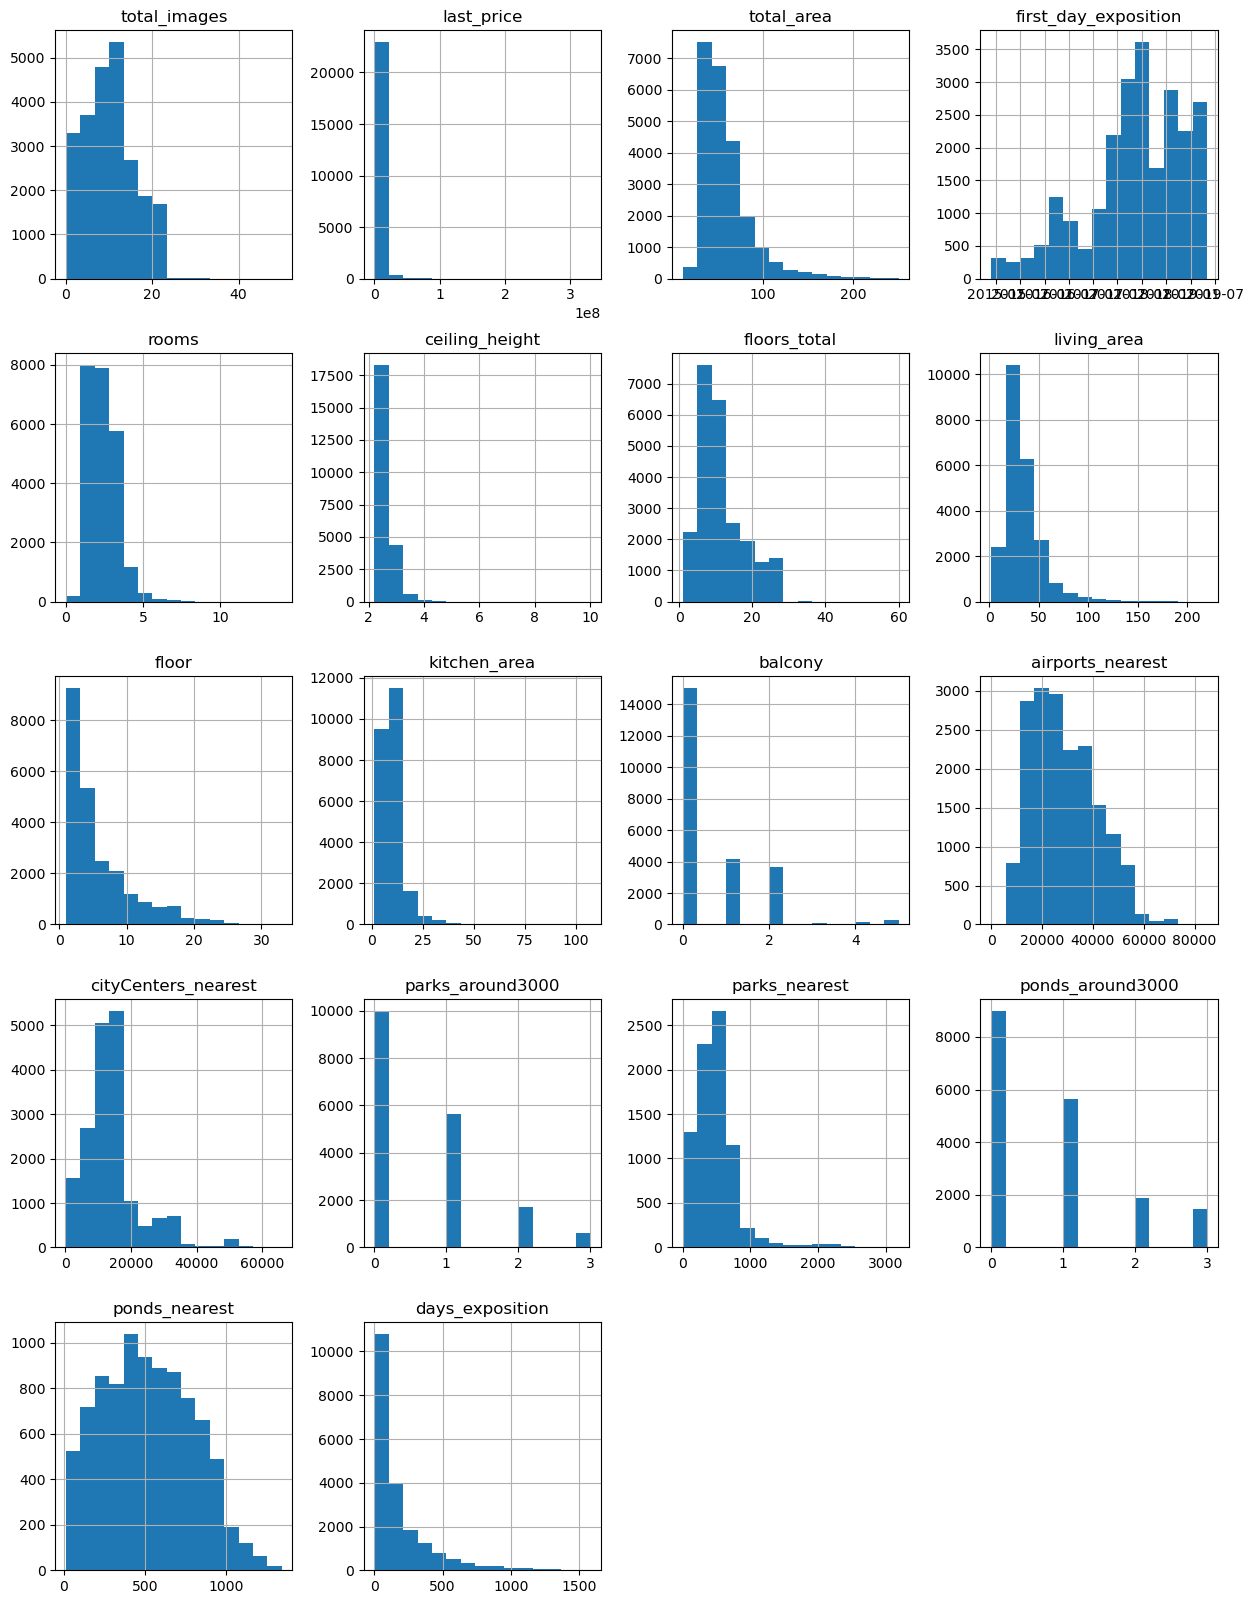

In [10]:
#всего 111 строк (0.5%). Не так критично для нашего датафрейма, можно удалить эти строки. При этом мы получим улучшенные гистограммы. Проверим:
df = df.loc[df['total_area'] < 250]

df.hist(bins=15, figsize=(15, 20))
df.head()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23433 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23433 non-null  int64         
 1   last_price            23433 non-null  float64       
 2   total_area            23433 non-null  float64       
 3   first_day_exposition  23433 non-null  datetime64[ns]
 4   rooms                 23433 non-null  int64         
 5   ceiling_height        23433 non-null  float64       
 6   floors_total          23433 non-null  int32         
 7   living_area           23433 non-null  float64       
 8   floor                 23433 non-null  int64         
 9   is_apartment          23433 non-null  bool          
 10  studio                23433 non-null  bool          
 11  open_plan             23433 non-null  bool          
 12  kitchen_area          23433 non-null  float64       
 13  balcony         

In [12]:
df.isnull().sum() #поверим наши пропуски еще раз

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5511
cityCenters_nearest      5490
parks_around3000         5489
parks_nearest           15479
ponds_around3000         5489
ponds_nearest           14481
days_exposition          3143
dtype: int64

**Вывод**\
Мы убрали и оптимизировали большое количество пропусков с минимальным количеством потерь строк в датафрейме (3,7%), а также избавились от аномально низких и высоких потолков и выбросов по общей площади.

Добавим столбец с ценой одного квадратного метра **'price_of_meter'**

In [13]:
df['price_of_meter'] = df['last_price']/df['total_area']

Далее добавим столбцы:\
день недели публикации **'day_of_week_publication'**,\
месяц публикации **'month_of_publication'**,\
год публикации **'year_of_publication'**.

In [14]:
df['day_of_week_publication'] = df['first_day_exposition'].dt.weekday
df['month_of_publication'] = df['first_day_exposition'].dt.month
df['year_of_publication'] = df['first_day_exposition'].dt.year

Добавим столбец , в котором отразим названия этажей **'name_floor'**:\
первый этаж = **"первый"**,\
если этаж совпадет с количеством этажей в доме = **"последний"**\
промежуточные = **"другой"**.

In [15]:
def name_floor(row):
    if row['floor'] == 1:
        return 'первый'
    if row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['name_floor'] = df.apply(name_floor, axis=1)

Добавим столбец со значением расстояния до центра, переведенного из М в КМ **'cityCenters_nearest_km'**.

In [16]:
df['cityCenters_nearest_km'] = (df['cityCenters_nearest']/1000).round()

In [17]:
#проверим результат
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter,day_of_week_publication,month_of_publication,year_of_publication,name_floor,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.600000,1,False,False,False,11.000000,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,90.340909,9,False,False,False,27.401064,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0


Столбцы добавлены, функция работает корректно.

### Проведем исследовательский анализ данных

In [18]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_of_meter,day_of_week_publication,month_of_publication,year_of_publication,cityCenters_nearest_km
count,23433.000000,2.343300e+04,23433.000000,23433.000000,23433.000000,23433.000000,23433.000000,23433.000000,23433.000000,23433.000000,17922.000000,17943.000000,17944.000000,7954.000000,17944.000000,8952.000000,20290.000000,2.343300e+04,23433.000000,23433.000000,23433.000000,17943.000000
mean,9.865275,6.188506e+06,58.938100,2.051167,2.696163,10.694619,33.786313,5.880254,10.349488,0.594888,28806.373619,14236.274369,0.607724,491.351396,0.765827,519.302055,180.214243,9.882259e+04,2.566295,6.401784,2017.371954,14.229839
std,5.672734,7.058699e+06,28.790554,1.027649,0.230775,6.596859,18.788294,4.874999,5.531472,0.960807,12657.424822,8610.893334,0.798265,342.052892,0.936304,278.130818,219.136485,4.703089e+04,1.788340,3.492653,1.036630,8.618974
min,0.000000,1.219000e+04,12.000000,0.000000,2.200000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000,1.118349e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18539.000000,9325.000000,0.000000,288.000000,0.000000,295.000000,45.000000,7.653061e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26770.000000,13138.000000,0.000000,455.000000,0.000000,503.000000,95.000000,9.491525e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.700000,16.000000,42.000000,8.000000,11.900000,1.000000,37294.000000,16295.000000,1.000000,613.000000,1.000000,732.250000,230.000000,1.140065e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,3.300000e+08,249.900000,14.000000,10.000000,60.000000,220.000000,33.000000,107.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000,1.736842e+06,6.000000,12.000000,2019.000000,66.000000


Посмотрим, каких квартир большинство на рынке

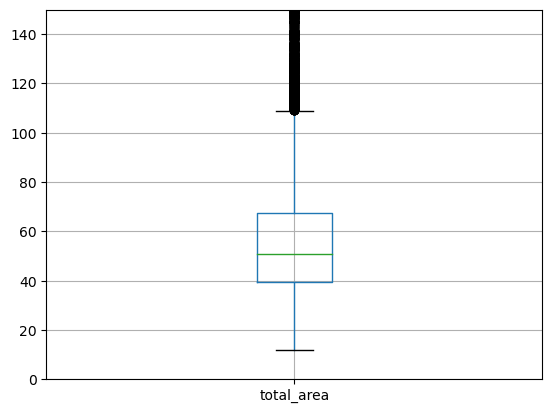

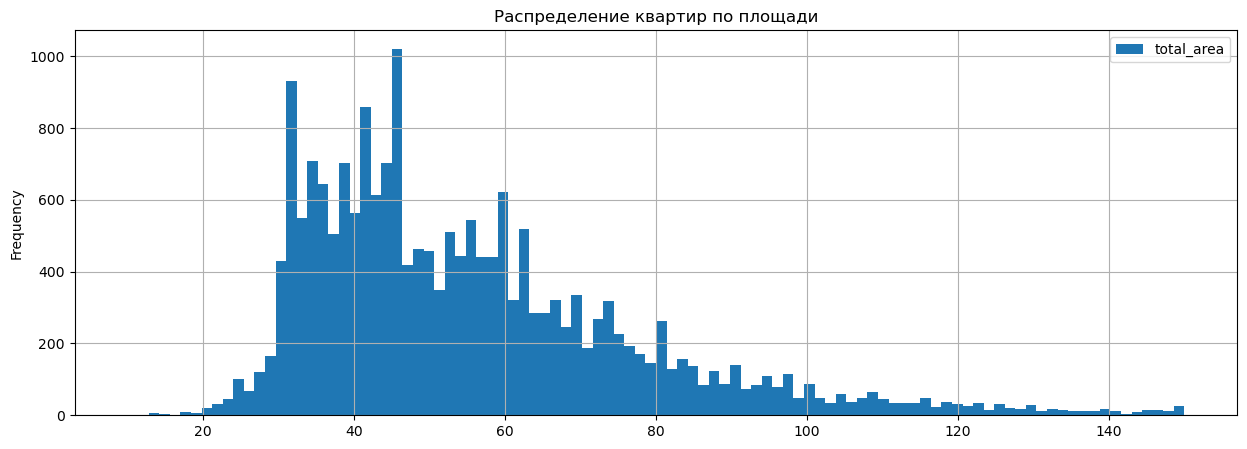

In [59]:
df.boxplot('total_area')
plt.ylim(0, 150)
df.plot(y='total_area', bins=100, title='Распределение квартир по площади', kind='hist', grid=True, range=(10,150), figsize = (15,5))
plt.show()

Видим распределение Гаусса.\
Медианное значение площади 52 м2.\
Выбросы начинаются со 110 м2, но не будем их удалять.\
Большинсвто квартир имеют площадь от 30 до 60 м2.

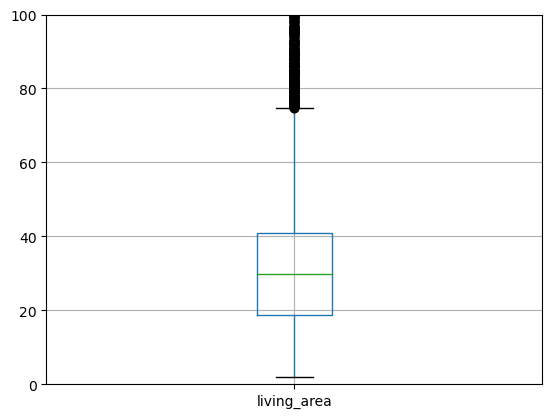

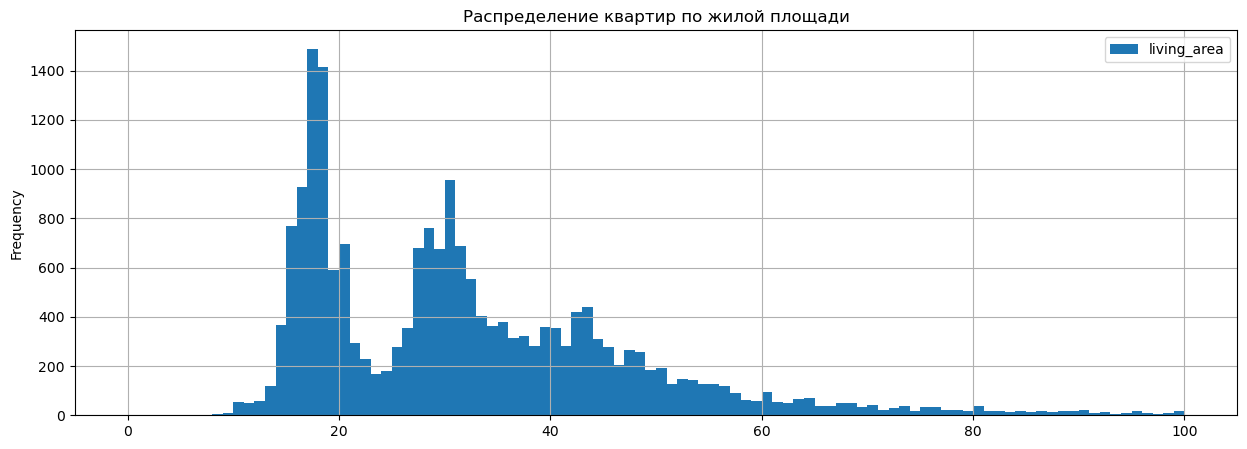

In [60]:
df.boxplot('living_area')
plt.ylim(0, 100)
df.plot(y='living_area', bins=100, title='Распределение квартир по жилой площади', kind='hist', grid=True, range=(0,100), figsize = (15,5))
plt.show()

Распределение Гаусса.\
Медиана 30 м2.\
Выбросы начинаются с 75 м2.

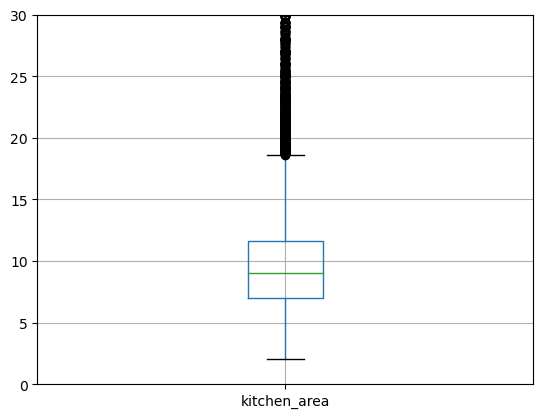

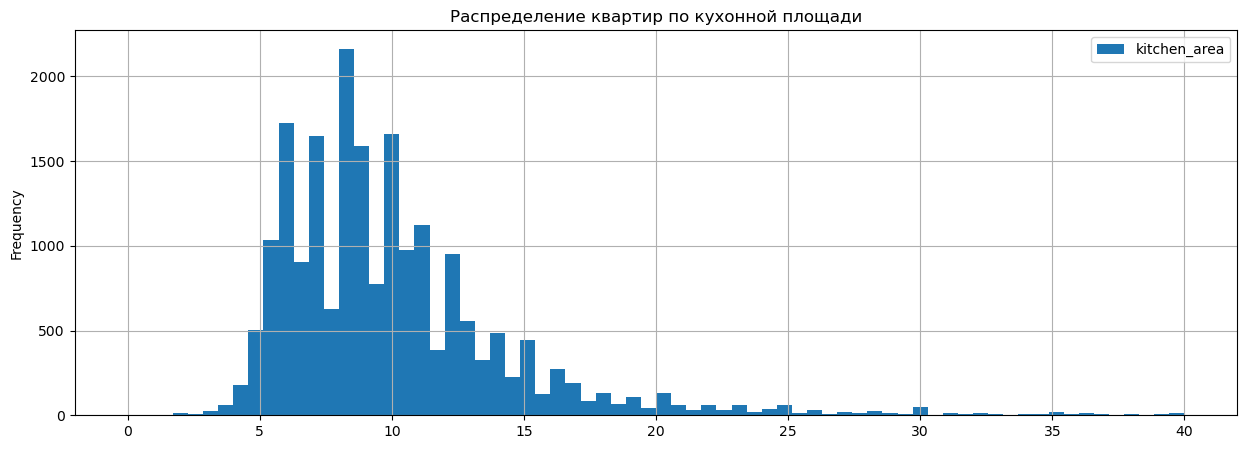

In [61]:
df.boxplot('kitchen_area')
plt.ylim(0, 30)
df.plot(y='kitchen_area', bins=70, title='Распределение квартир по кухонной площади', kind='hist', grid=True, range=(0,40), figsize = (15,5))
plt.show()

Распределение Гаусса.\
Медиана равна 9 м2.\
Выбросы начинаются с 19 м2.

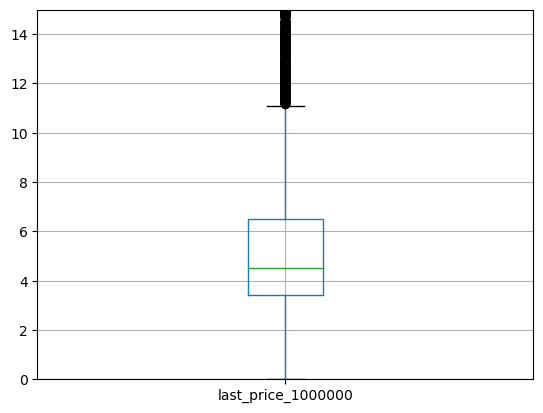

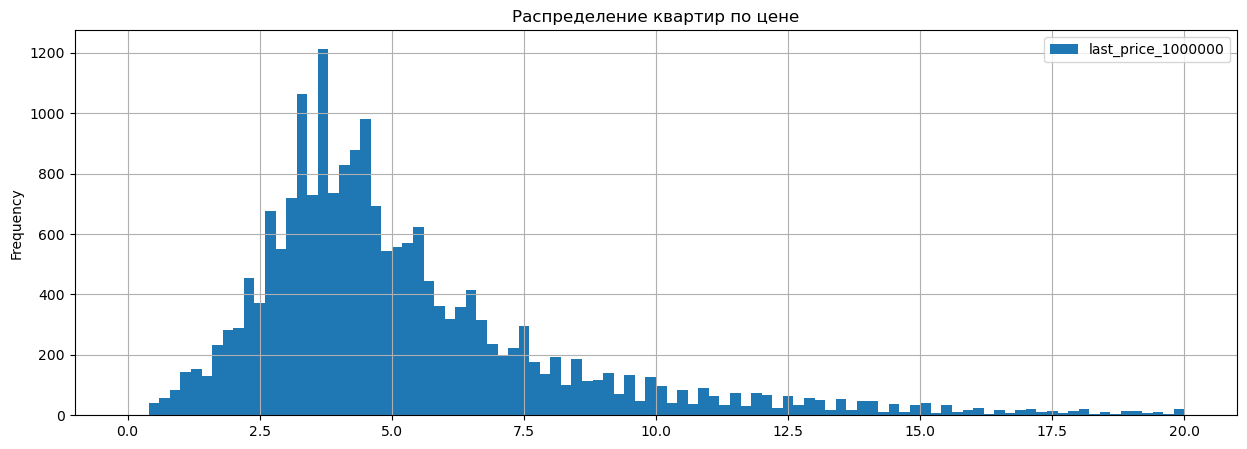

In [71]:
df['last_price_1000000'] = df['last_price']/1000000.0
df.boxplot('last_price_1000000')
plt.ylim(0, 15)
df.plot(y='last_price_1000000', bins=100, title='Распределение квартир по цене', kind='hist', grid=True, range=(0,20), figsize = (15,5))
plt.show()

Распределение Гаусса.\
Медиана равна 4.6 млн.\
Выбросы начинаются с 11.5 млн.

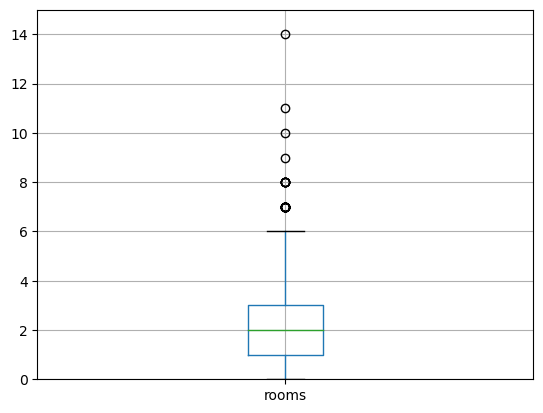

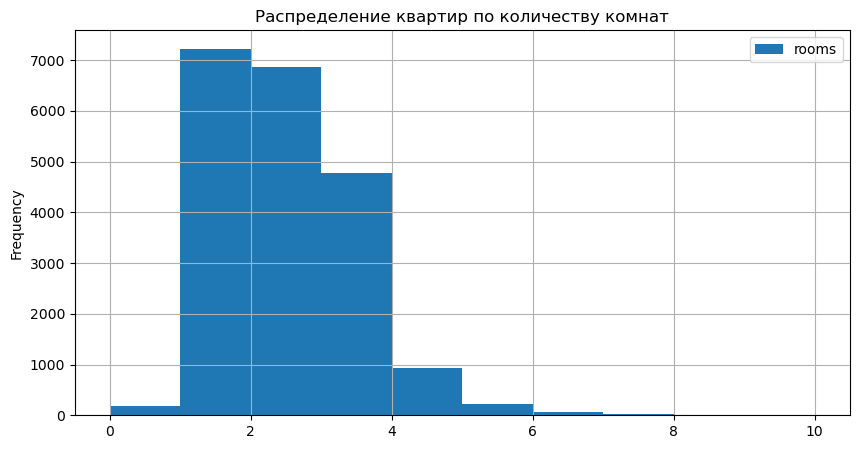

In [62]:
df.boxplot('rooms')
plt.ylim(0, 15)
df.plot(y='rooms', bins=10, title='Распределение квартир по количеству комнат', kind='hist', grid=True, range=(0,10), figsize = (10,5))
plt.show()

Распределение Пуассона.\
Медиана равна 2 комнатам.\
Выбросы начинаются с 6 комнат.\
На рынке большинство квартир 1-3 комнатных.

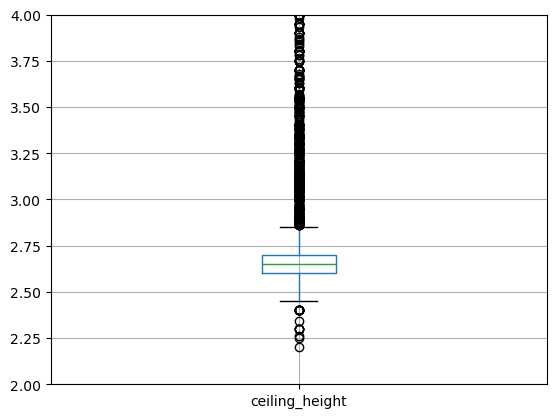

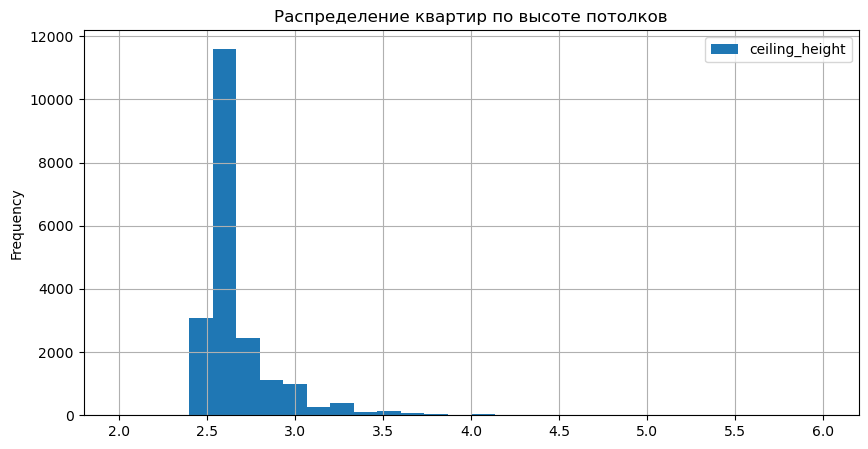

In [75]:
df.boxplot('ceiling_height')
plt.ylim(2, 4)
df.plot(y='ceiling_height', bins=30, title='Распределение квартир по высоте потолков', kind='hist', grid=True, range=(2,6), figsize = (10,5))
plt.show()

Рапределение Пуассона.\
Медиана равна 2.65 м (ожидаемо, мы ей заполнили большую часть пропусков).
Высота потолков в промежутке 2.4 - 2.7 считается стандартом. Это нам подтверждает и график.

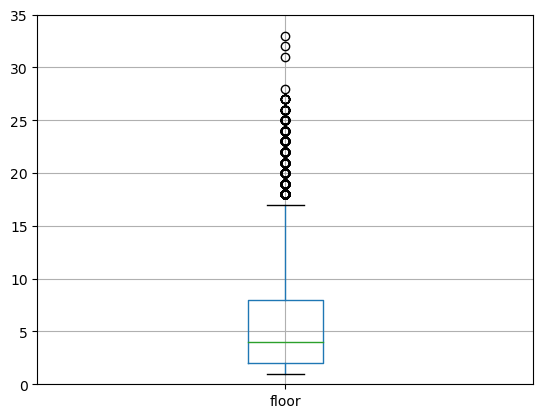

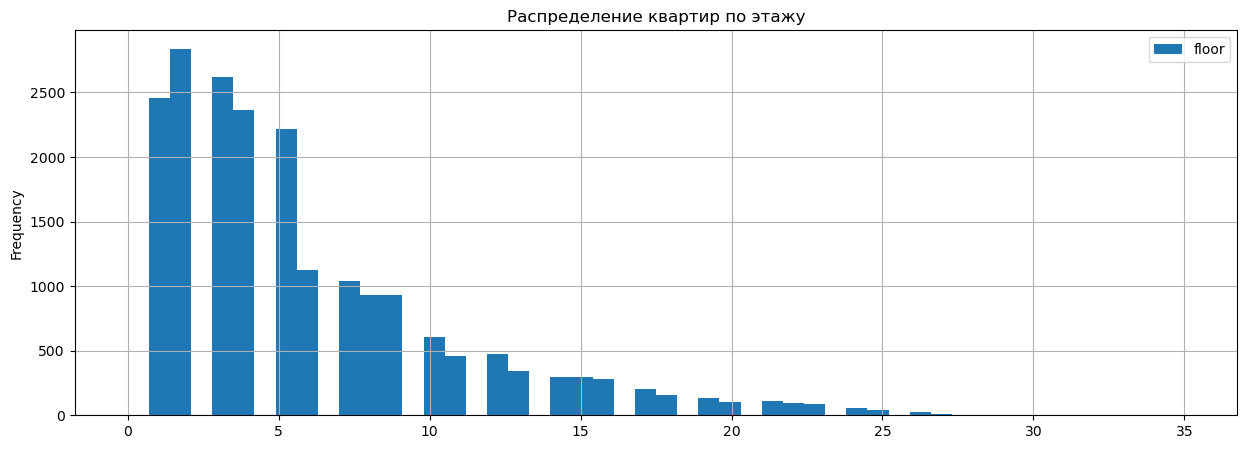

In [76]:
df.boxplot('floor')
plt.ylim(0, 35)
df.plot(y='floor', bins=50, title='Распределение квартир по этажу', kind='hist', grid=True, range=(0,35), figsize = (15,5))
plt.show()

Распределние Пуассона.\
Медиана 4.\
Закономерно, так как в ленинградской области преобладают низкие дома.

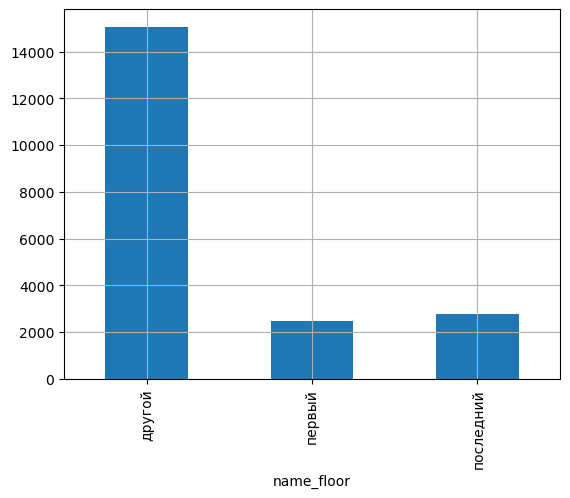

In [77]:
floor_group = df.groupby('name_floor')['floors_total'].count()
floor_group.plot(x='name_floor', y='floors_total', kind='bar', grid=True)
plt.show()

Рапределение Гаусса.

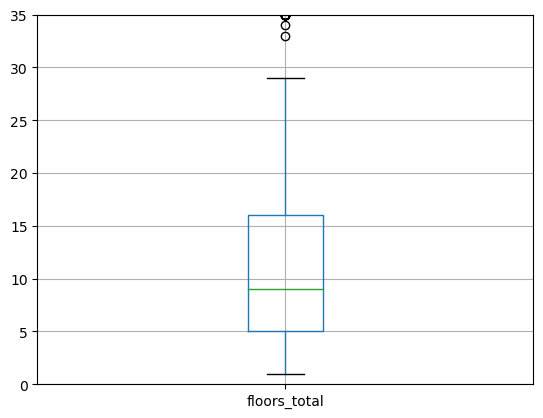

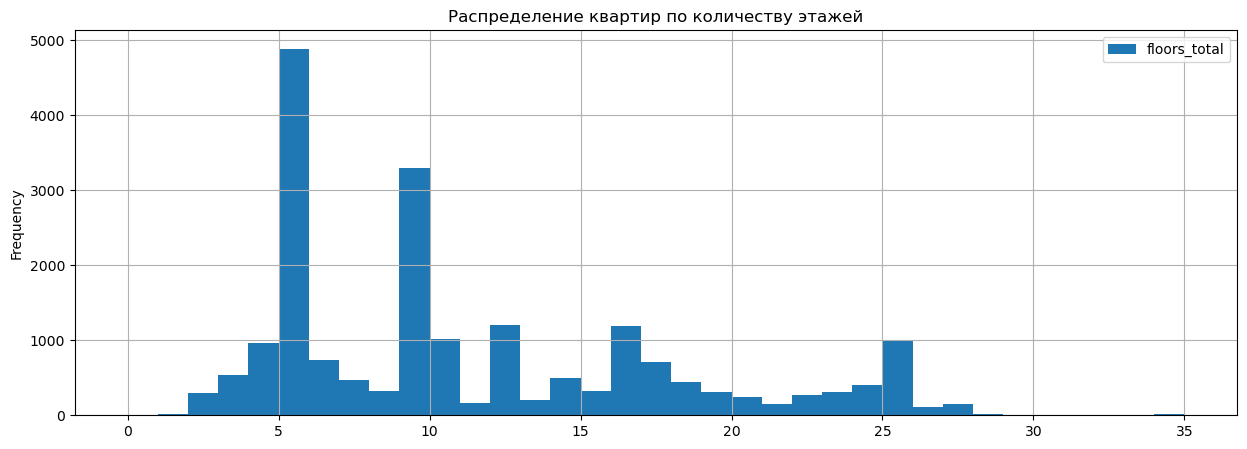

In [78]:
df.boxplot('floors_total')
plt.ylim(0, 35)
df.plot(y='floors_total', bins=35, title='Распределение квартир по количеству этажей', kind='hist', grid=True, range=(0,35), figsize = (15,5))
plt.show()

Рапределение Пуассона.\
График подтверждает наш предыдущий вывод "в ленинградской области преобладают низкие дома."

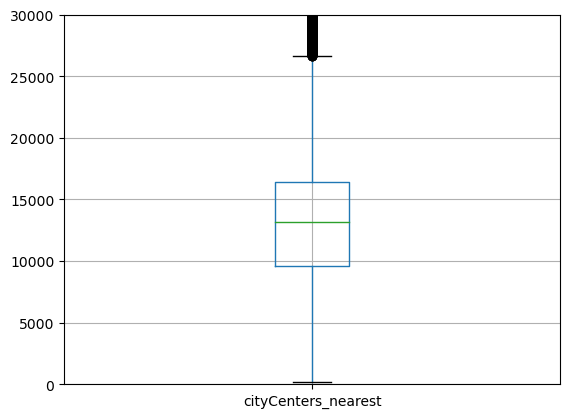

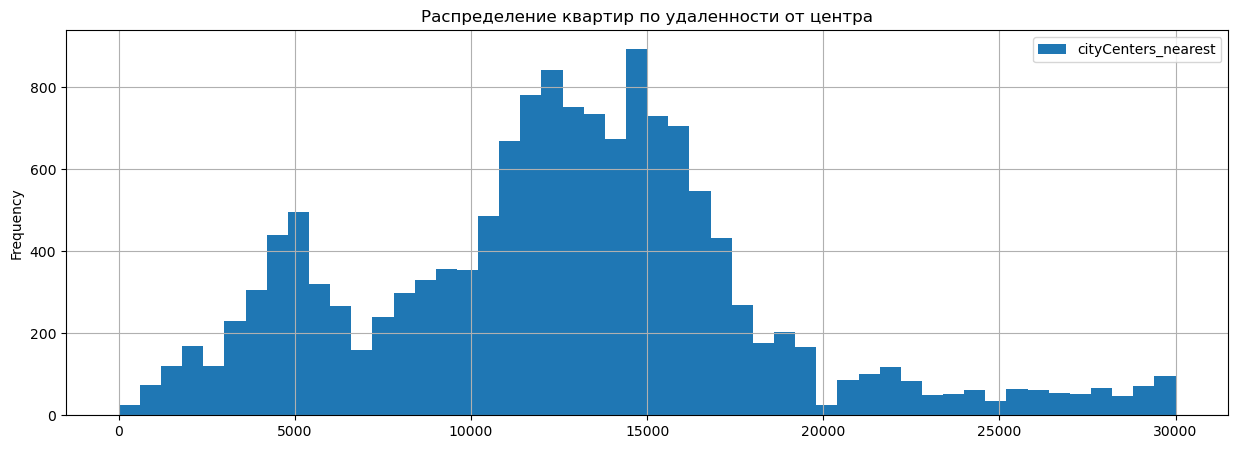

In [79]:
df.boxplot('cityCenters_nearest')
plt.ylim(0, 30000)
df.plot(y='cityCenters_nearest', bins=50, title='Распределение квартир по удаленности от центра', kind='hist', grid=True, range=(0,30000), figsize = (15,5))
plt.show()

Рапределение Гаусса.\
Медиана 13138м.

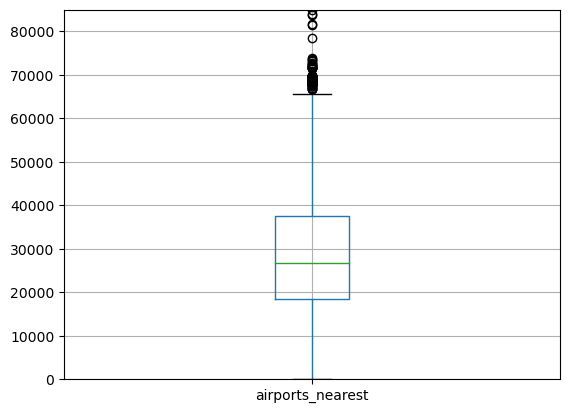

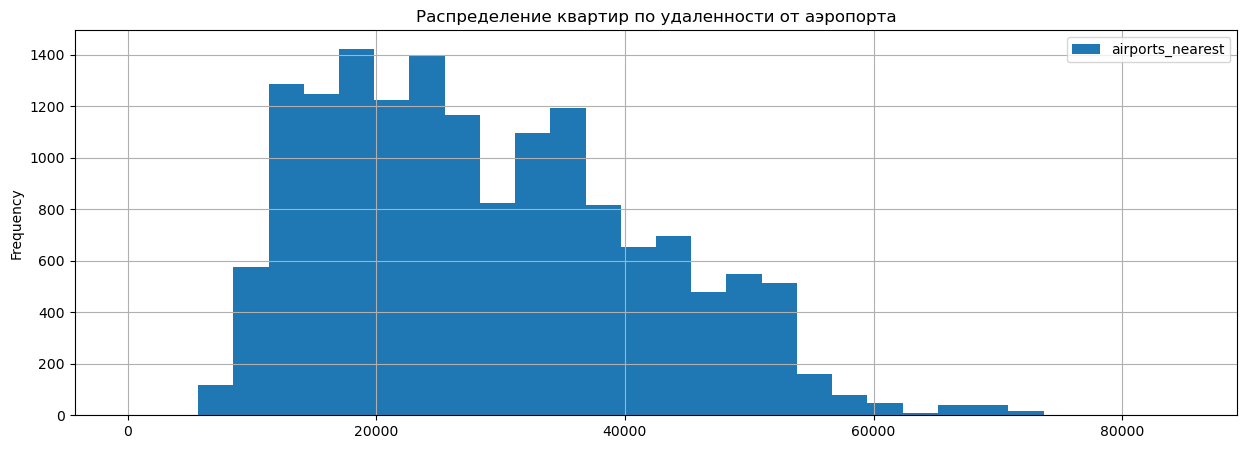

In [80]:
df.boxplot('airports_nearest')
plt.ylim(0, 85000)
df.plot(y='airports_nearest', bins=30, title='Распределение квартир по удаленности от аэропорта', kind='hist', grid=True, range=(0,85000), figsize = (15,5))
plt.show()

In [30]:
df['airports_nearest'].describe()

count    17922.000000
mean     28806.373619
std      12657.424822
min          0.000000
25%      18539.000000
50%      26770.000000
75%      37294.000000
max      84869.000000
Name: airports_nearest, dtype: float64

Подчистим данные для наглядности

In [31]:
airpots_normal_nearest = df.query('63000 > airports_nearest > 5000')

In [32]:
airpots_normal_nearest['airports_nearest'].describe()

count    17796.000000
mean     28523.980895
std      12231.201956
min       6450.000000
25%      18491.500000
50%      26646.000000
75%      36969.000000
max      62111.000000
Name: airports_nearest, dtype: float64

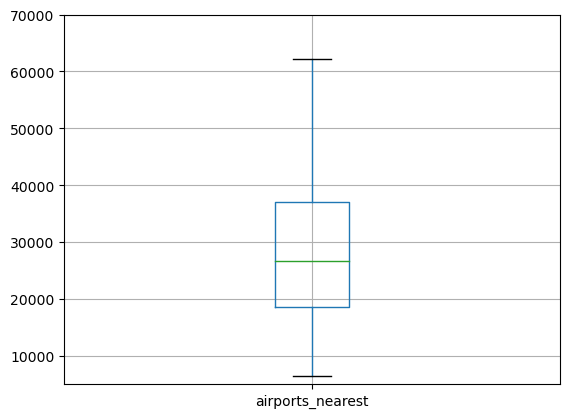

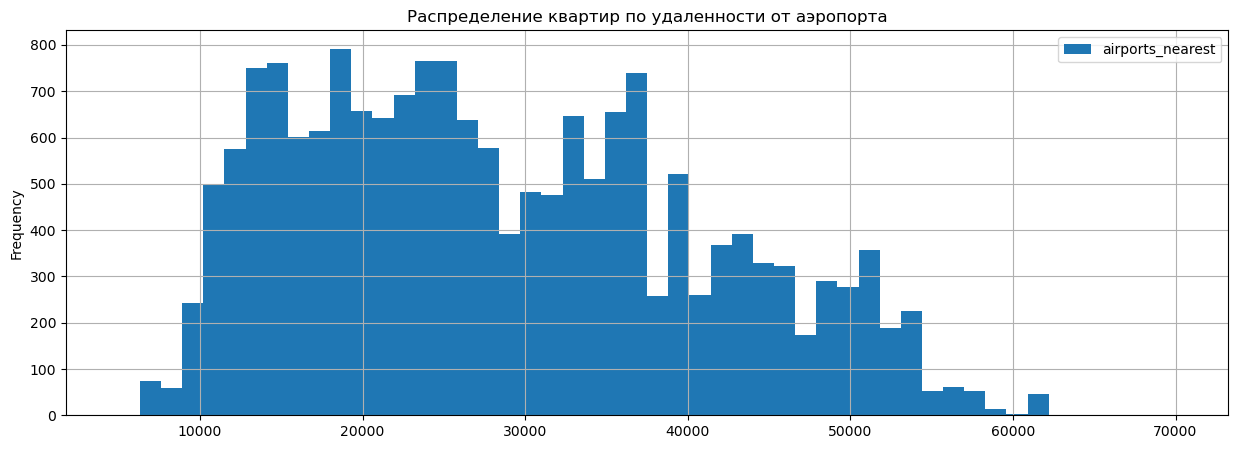

In [81]:
airpots_normal_nearest.boxplot('airports_nearest')
plt.ylim(5000, 70000)
airpots_normal_nearest.plot(y='airports_nearest', bins=50, title='Распределение квартир по удаленности от аэропорта', kind='hist', grid=True, range=(5000,70000), figsize = (15,5))
plt.show()

Здесь наблюдаем распределение Пуассона.\
Медиана равна 26938 м.

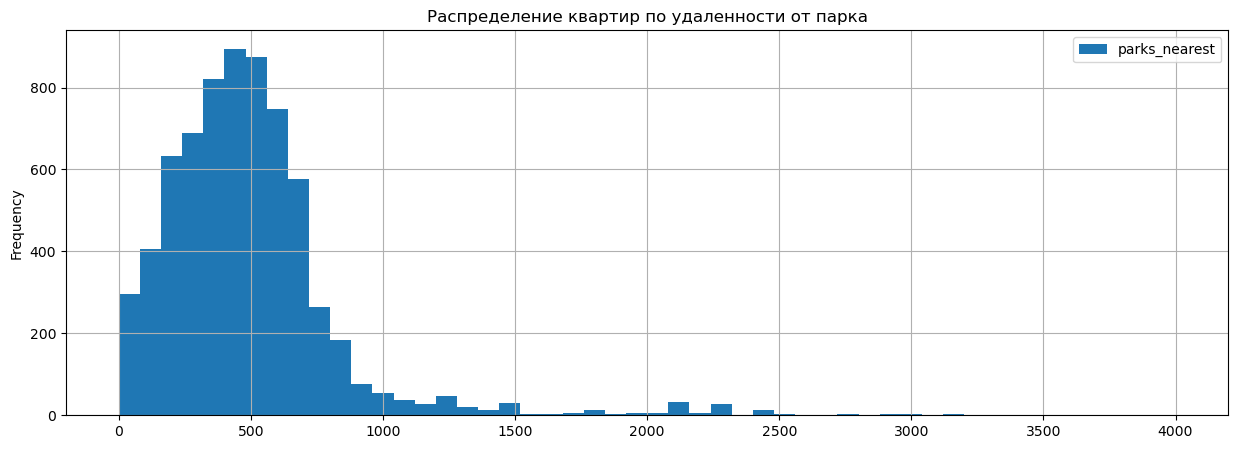

In [82]:
df.plot(y='parks_nearest', bins=50, title='Распределение квартир по удаленности от парка', kind='hist', grid=True, range=(0,4000), figsize = (15,5))
plt.show()

Рапределенние Гаусса.\
Большинство квартир находятся в близости от парков.

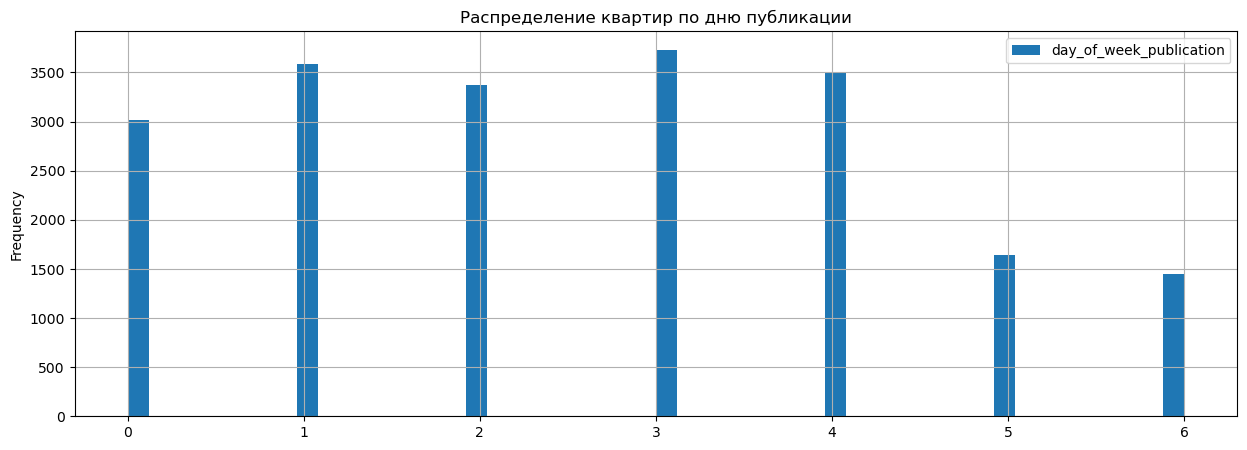

In [89]:
df.plot(y='day_of_week_publication', bins=50, title='Распределение квартир по дню публикации', kind='hist', grid=True, range=(0,6), figsize = (15,5))
plt.show()

Видно, что реже всего люди стремятся опубликовать объявление в субботу и воскресенье.

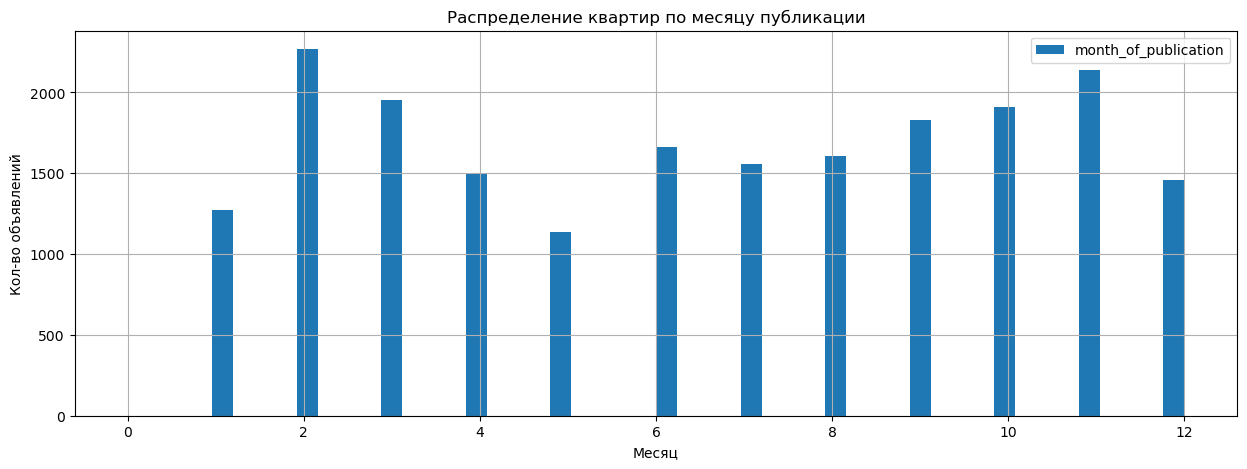

In [90]:
ax = df.plot(y='month_of_publication', bins=50, title='Распределение квартир по месяцу публикации', kind='hist', grid=True, range=(0,12), figsize = (15,5))
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во объявлений')
plt.show()

Видим, что месяц публикации не влияет на количество объявлений. Разве что в январе и мае просадка. Оно и понятно, у людей праздники))

**Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.** 

In [37]:
#для начала удалим все пропущенные значения в столбце days_exposition, так как мы изучаем ПРОДАННЫЕ (закрытые) объявления.
df.dropna(subset=['days_exposition'], inplace = True, axis = 0)
df['days_exposition'] = df['days_exposition'].astype('int')

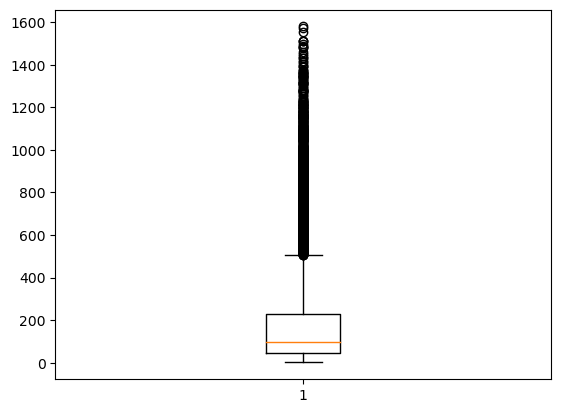

In [91]:
plt.boxplot(df['days_exposition'])
plt.show()

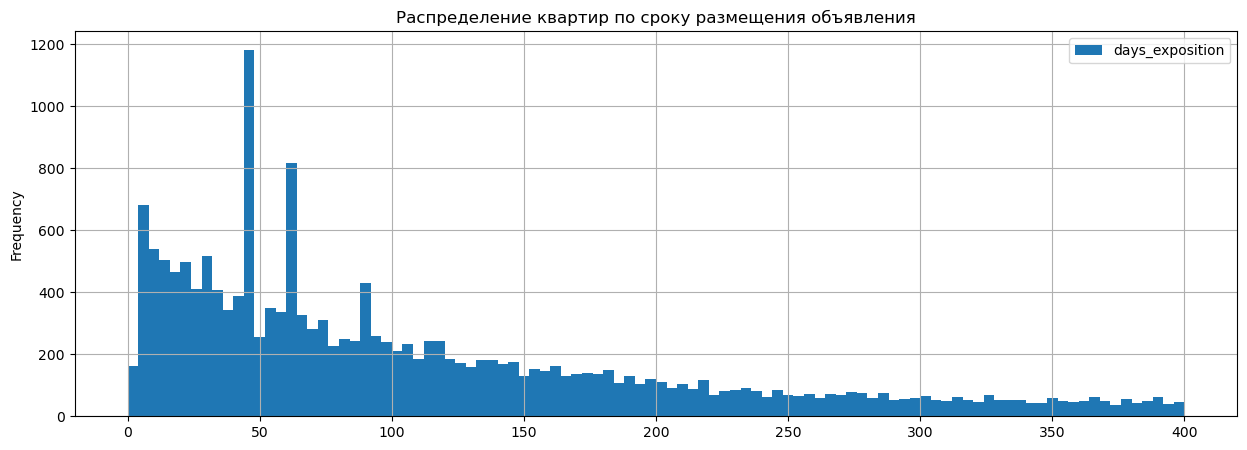

In [92]:
df.plot(y='days_exposition', bins=100, title='Распределение квартир по сроку размещения объявления', kind='hist', grid=True, range=(0,400), figsize = (15,5))
plt.show()

Видно 3 аномалии, вероятнее всего это дни, через которые публикации снимаются с площадки. По правилам площадки, объявления снимают через 45, 60, 95 дней. Нас интересуют сроки продажи квариры, а эти аномалии нам мешают адекватно взглянуть на график. Создадим новую переменную, в которой исключим дни автоматического снятия публикации.

In [40]:
days_exposition_sale = df.query('days_exposition != 45 & days_exposition != 60 & days_exposition != 95')

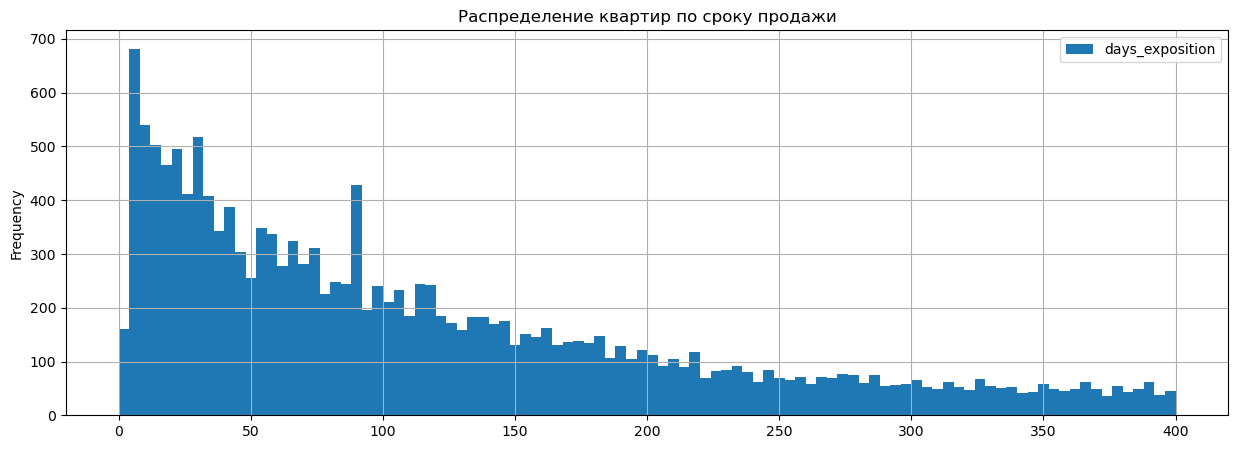

In [93]:
days_exposition_sale.plot(y='days_exposition', bins=100, title='Распределение квартир по сроку продажи', kind='hist', grid=True, range=(0,400), figsize = (15,5))
plt.show()

In [42]:
days_exposition_sale['days_exposition'].describe().round()

count    18811.0
mean       190.0
std        225.0
min          1.0
25%         42.0
50%        108.0
75%        249.0
max       1580.0
Name: days_exposition, dtype: float64

Теперь наглядно видим распределение Пуассона.\
В среднем квартиры продаются за 190 дней.\
Медианное значение 108 дней.\
Быстрые продажи от 1 до 42 дней. Долгие продажи свыше 249 дней.

**Изучим, какие факторы больше всего влияют на общую (полную) стоимость объекта:\
-общая площадь;\
-жилая площадь;\
-площадь кухни;\
-количество комнат;\
-этаж, на котором расположена квартира (первый, последний, другой);\
-дата размещения (день недели, месяц, год).**

Изучим зависимость цены от площади квартиры.\
Построим сводную таблицу с медианным значением цены для каждой площади в нашей выборке.

In [43]:
pivot_table_total_area = df.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']

Посчитаем корреляцию и слеаем вывод.

Корреляция: 0.6700305323595751


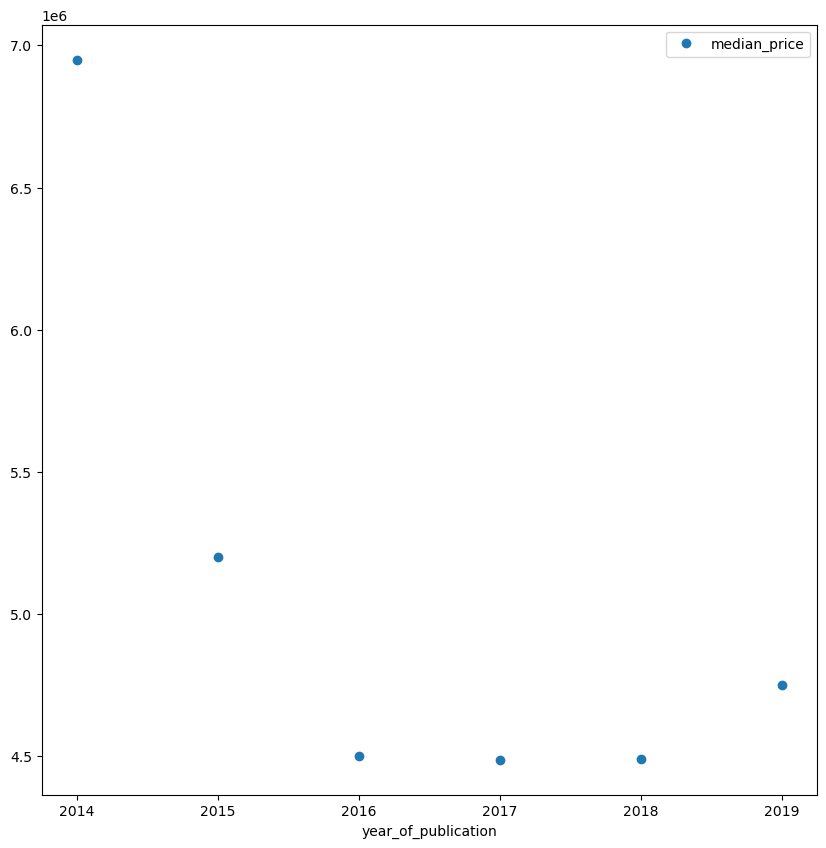

In [94]:
print('Корреляция:', df['total_area'].corr(df['last_price']))
pivot_table_total_area.plot(y = 'median_price', style = 'o', figsize=(10,10))
plt.show()

Вывод: Корреляция положительная средня 0.7. При увеличении площади квартиры, растет ее стоимость.

Изучим зависимость цены от жилой площади квартиры (аналогичино).

Корреляция: 0.583041357054392


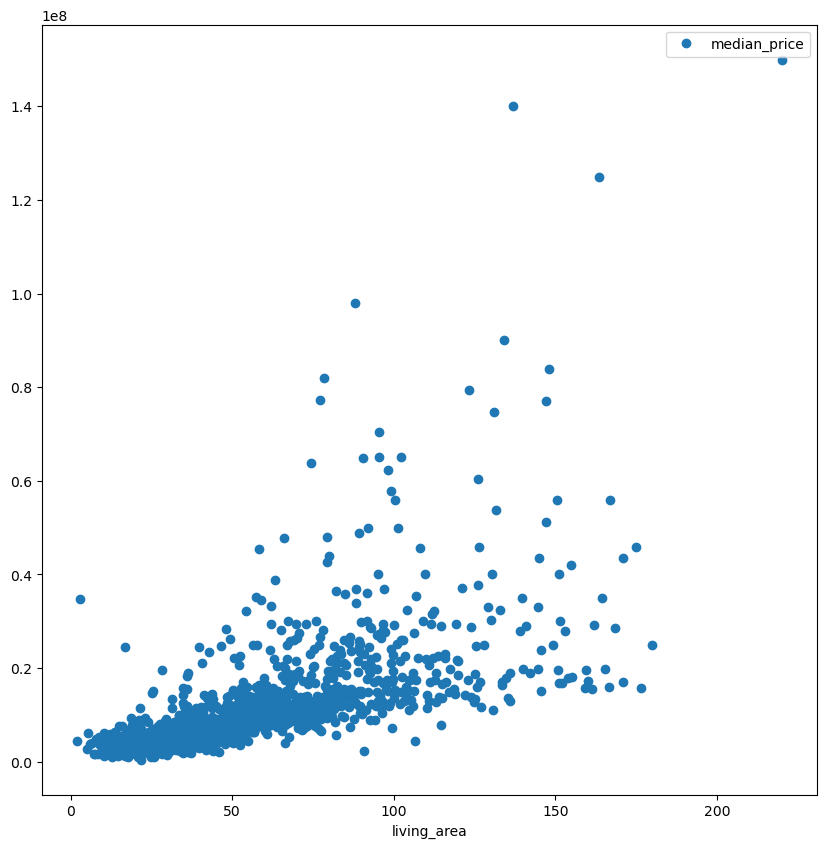

In [95]:
pivot_table_total_area = df.pivot_table(index = 'living_area', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
print('Корреляция:', df['living_area'].corr(df['last_price']))
pivot_table_total_area.plot(y = 'median_price', style = 'o', figsize=(10,10))
plt.show()

Вывод: Корреляция положительная средня 0.6. При увеличении жилой площади квартиры, растет ее стоимость.

Изучим зависимость цены от площади кухни квартиры (аналогичино).

Корреляция: 0.5366214974860879


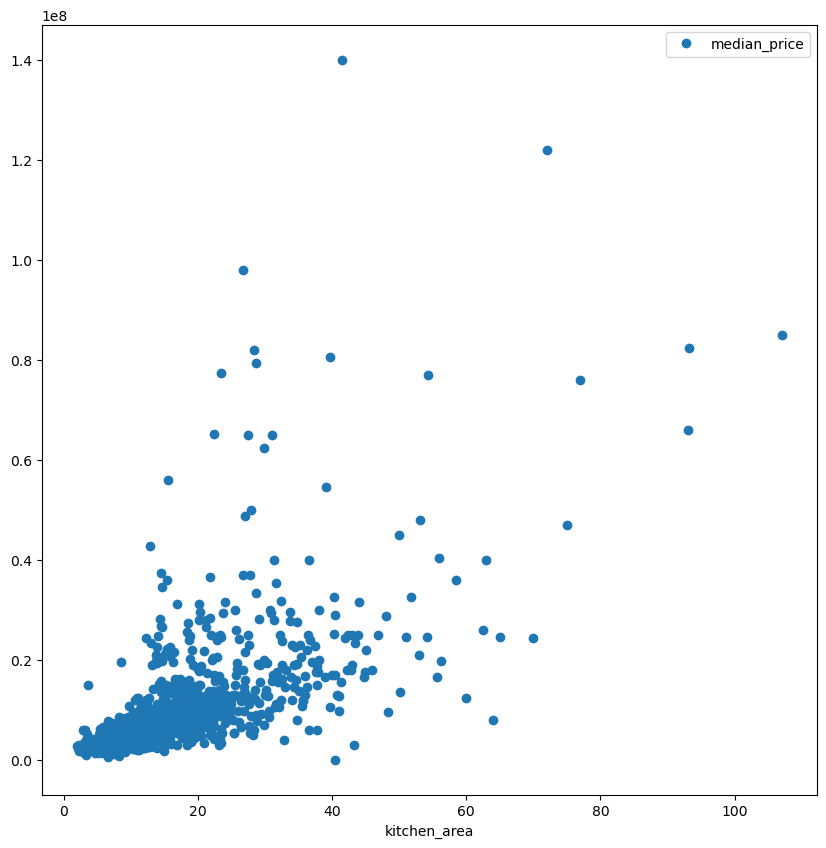

In [96]:
pivot_table_total_area = df.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
print('Корреляция:', df['kitchen_area'].corr(df['last_price']))
pivot_table_total_area.plot(y = 'median_price', style = 'o', figsize=(10,10))
plt.show()

Вывод: Корреляция положительная средня 0.5. При увеличении площади кухни квартиры, растет ее стоимость.

Изучим зависимость цены от количества комнат в квартире (аналогичино).

Корреляция: 0.39906659510986126


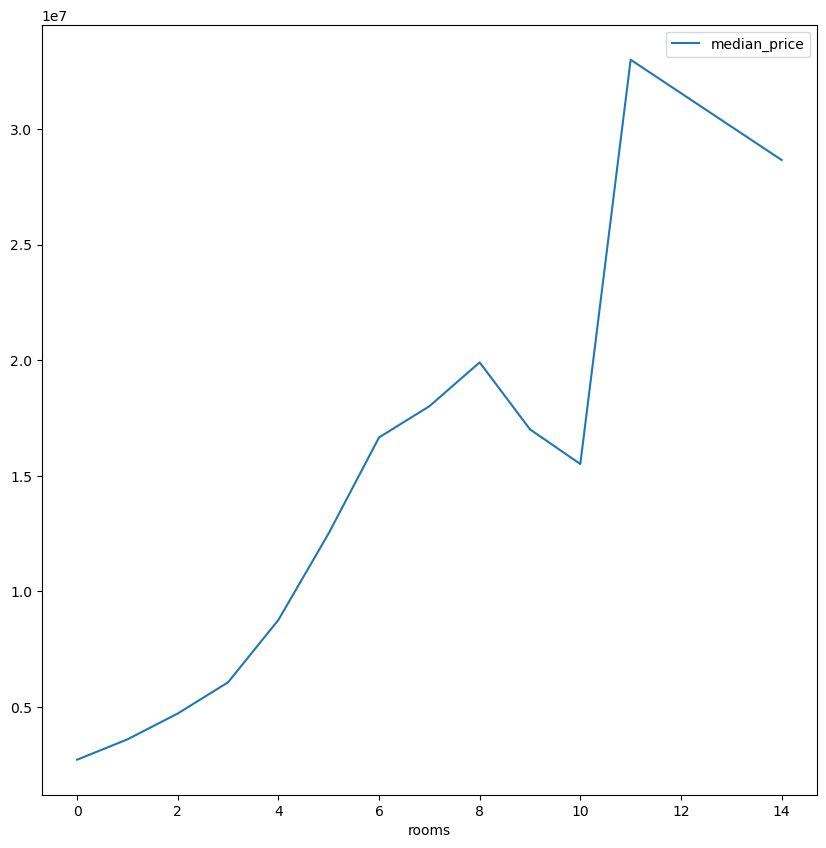

In [97]:
pivot_table_total_area = df.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
print('Корреляция:', df['rooms'].corr(df['last_price']))
pivot_table_total_area.plot(y = 'median_price', figsize=(10,10), kind='line')
plt.show()

Вывод: Корреляция положительная слабая 0.4.

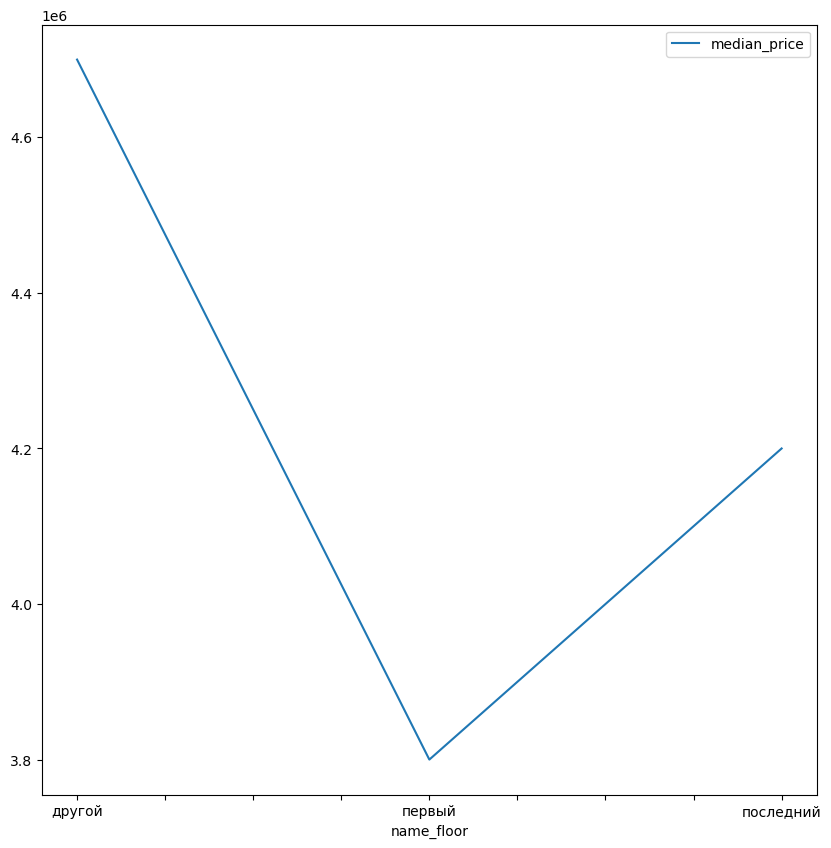

In [98]:
pivot_table_total_area = df.pivot_table(index = 'name_floor', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
pivot_table_total_area.plot(y = 'median_price', figsize=(10,10), kind='line')
plt.show()

Вывод: на первом этаже квартиры дешевле.

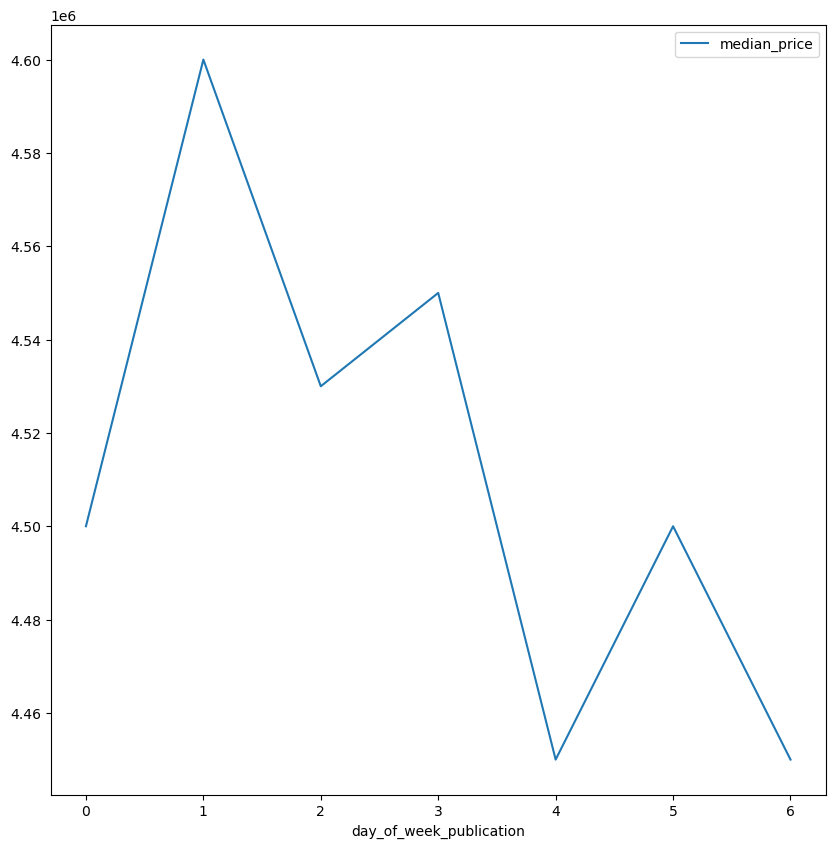

In [100]:
pivot_table_total_area = df.pivot_table(index = 'day_of_week_publication', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
pivot_table_total_area.plot(y = 'median_price', figsize=(10,10), kind='line')
plt.show()

Не сказать, что цена значительно меняется, но мы видим, что в пятницу и воскресение цены самые низкие!

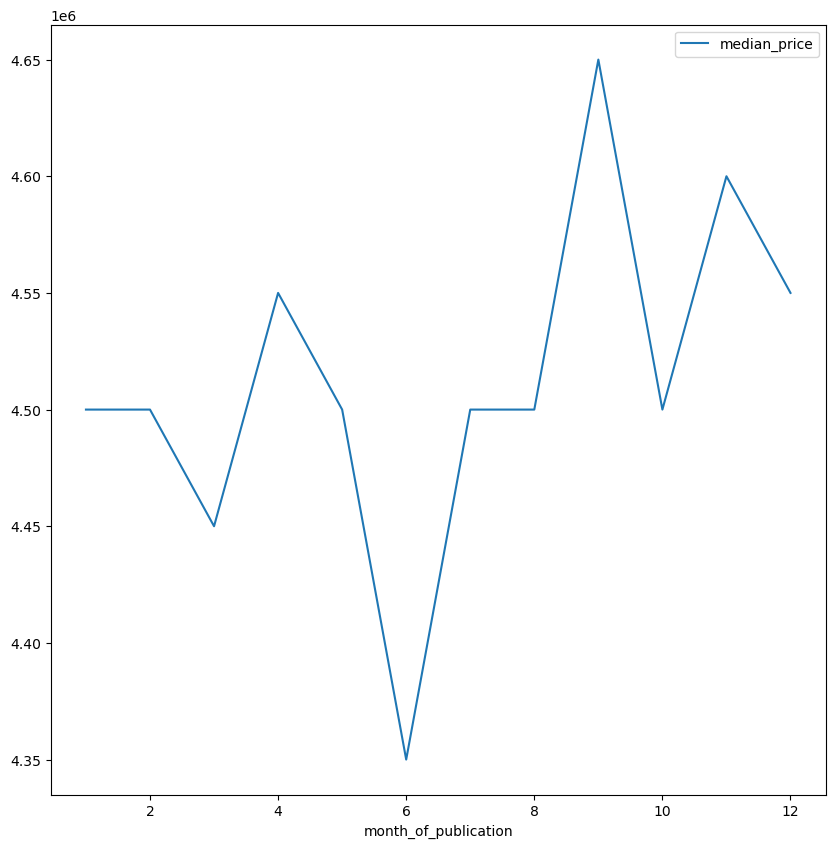

In [101]:
pivot_table_total_area = df.pivot_table(index = 'month_of_publication', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
pivot_table_total_area.plot(y = 'median_price', figsize=(10,10), kind='line')
plt.show()

Самая низкая стоимость квартир в июне, самая высокая стоимоть в октябре. Типичная картина: летом цена падает, а после растет. Отпуска)

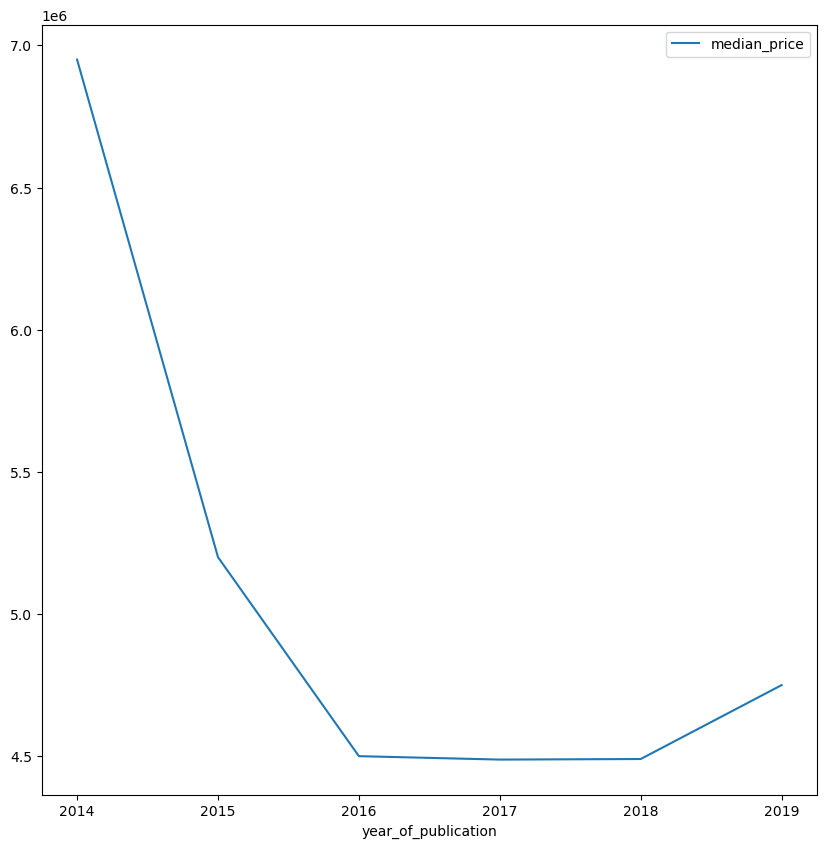

In [102]:
pivot_table_total_area = df.pivot_table(index = 'year_of_publication', values = 'last_price', aggfunc = 'median')
pivot_table_total_area.columns = ['median_price']
pivot_table_total_area.plot(y = 'median_price', figsize=(10,10), kind='line')
plt.show()

\
**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.**

In [112]:
pivot_table_locality_name = df.pivot_table(index = 'locality_name', values = 'price_of_meter', aggfunc = ['count', 'mean'])
pivot_table_locality_name.columns = ['count', 'mean']
pivot_table_locality_name = pivot_table_locality_name.sort_values('count', ascending = False).head(10)
pivot_table_locality_name

,count,mean
locality_name,,
Санкт-Петербург,13485,111604.439168
поселок Мурино,547,85691.011789
поселок Шушары,407,77872.600324
Всеволожск,339,68570.615292
Колпино,307,74763.339311
Пушкин,305,102073.791546
поселок Парголово,302,89505.043917
деревня Кудрово,299,92473.547576
Гатчина,268,67928.326990


Найдем населенный пункт с самой низкой стоимостью за квадратный метр:

In [54]:
pivot_table_locality_name[pivot_table_locality_name['mean'] == pivot_table_locality_name['mean'].min()]

,count,mean
locality_name,,
Выборг,206,57184.099136


Найдем населенный пункт с самой высокой стоимостью за квадратный метр:

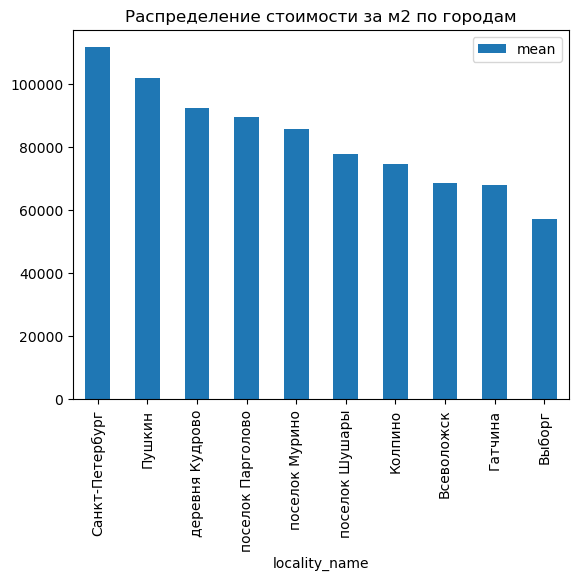

In [117]:
pivot_table_locality_name.sort_values('mean', ascending=False).plot(y='mean', kind='bar', title='Распределение стоимости за м2 по городам')
plt.show()

In [55]:
pivot_table_locality_name[pivot_table_locality_name['mean'] == pivot_table_locality_name['mean'].max()]

,count,mean
locality_name,,
Санкт-Петербург,13485,111604.439168


Вывод: Самая высокая стоимость квадратного метра в г. Санкт-Петербурге, а самая низкая в г. Выборг.

Теперь выясним как стоимость объектов в СПБ зависит от расстояния до центра города.\
Сделаем срез по Санкт-Петербургу и построим сводную таблицу.

In [121]:
locality_name_spb = df.query('locality_name == "Санкт-Петербург"').pivot_table(index='cityCenters_nearest_km', values='last_price_1000000')
locality_name_spb.head()

,last_price_1000000
cityCenters_nearest_km,
0.0,23.232368
1.0,17.962491
2.0,15.567633
3.0,9.716634
4.0,10.930599


Теперь на графике наглядно покажем рапределние цены в зависимости от удаленности объекта от центра города.

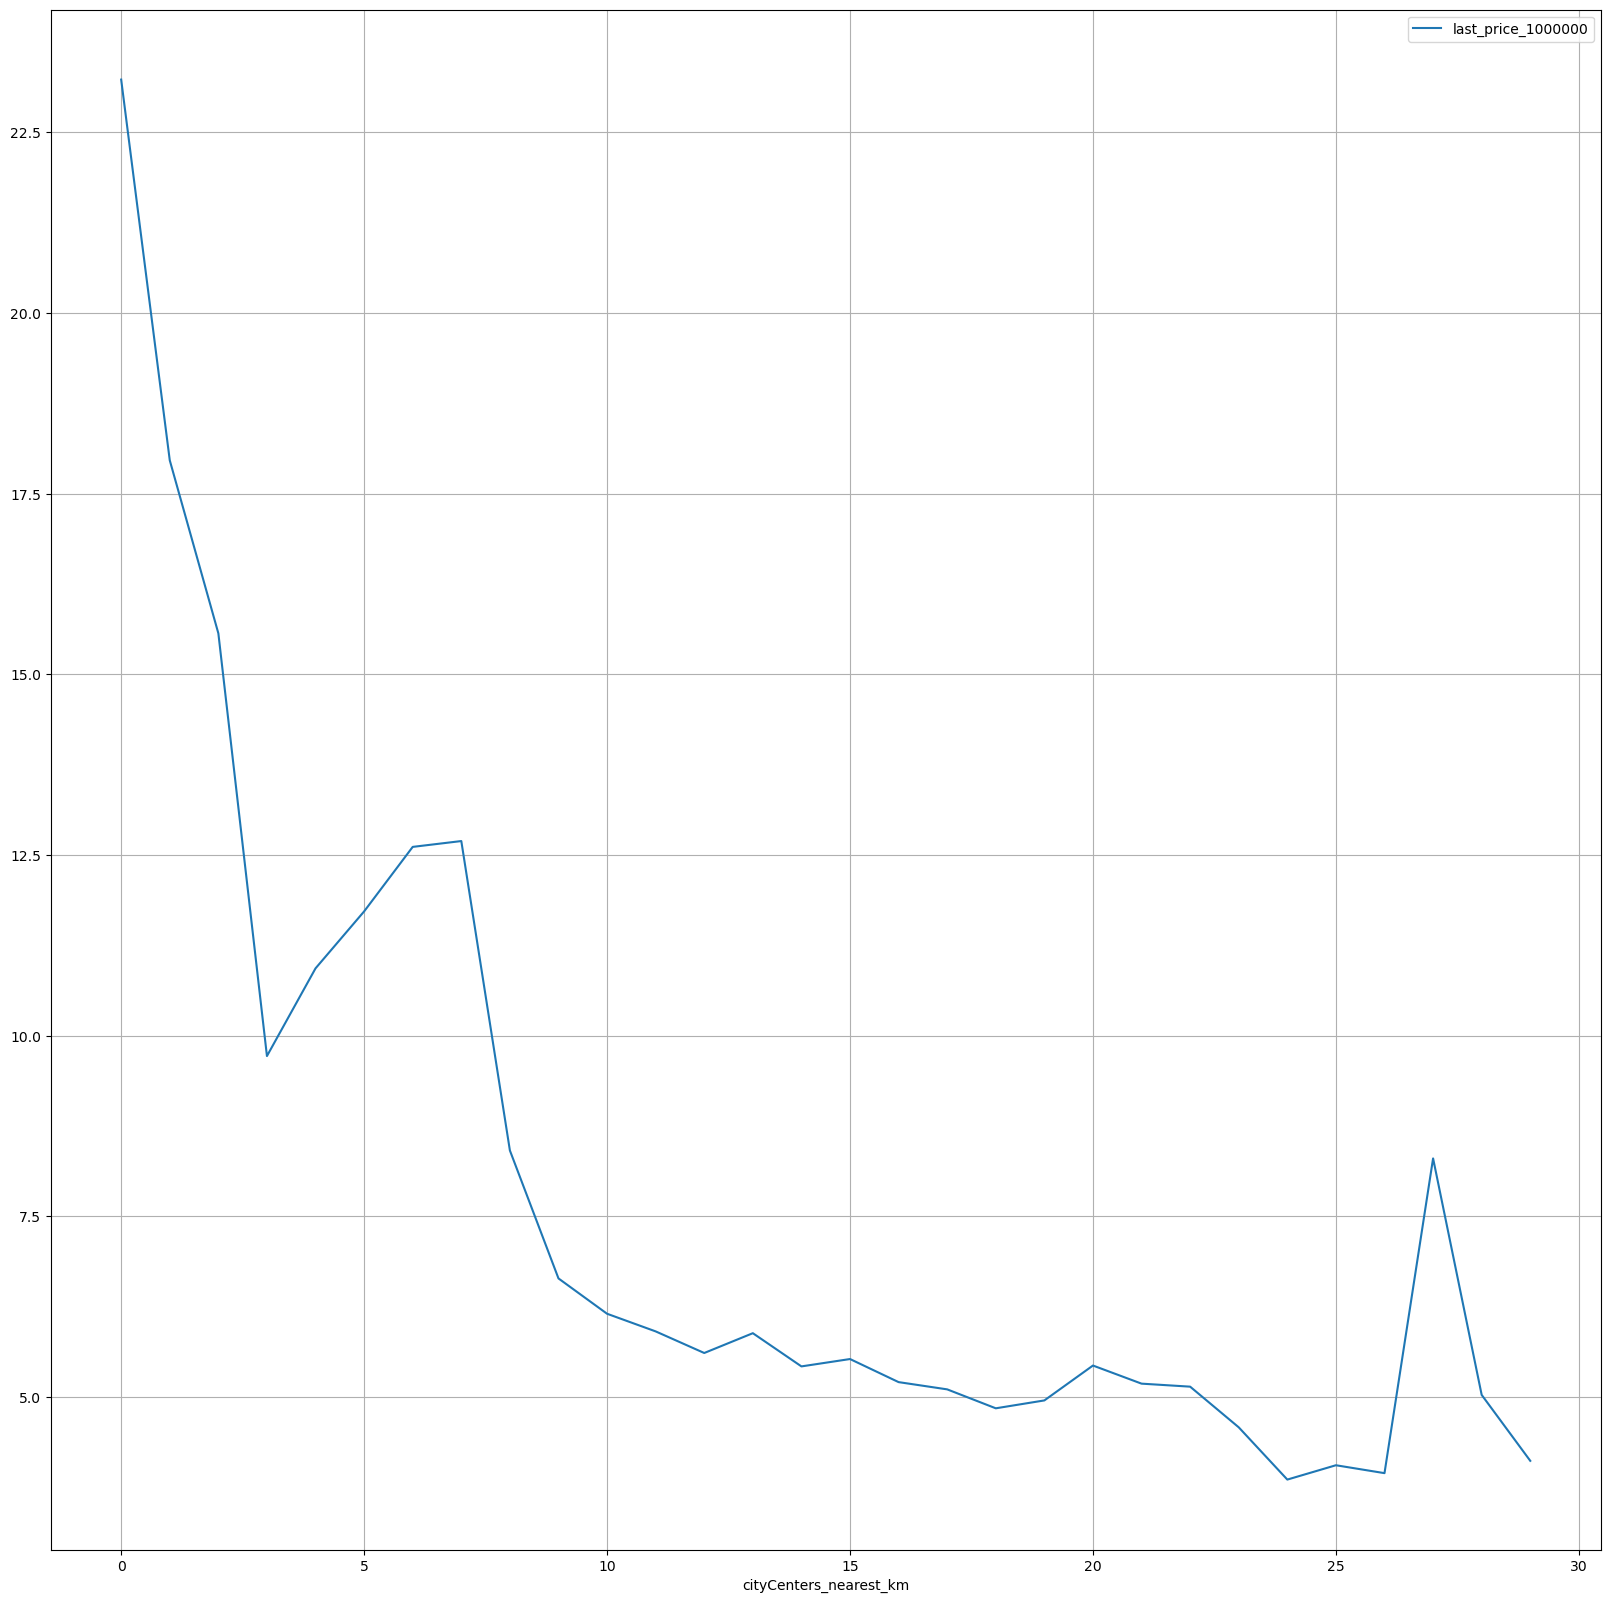

In [120]:
locality_name_spb.plot(kind='line', figsize=(20, 20), grid=True)
plt.show()

На данном графике мы видим как удаленность от центра влияет на строимость объекта. Чем дальше находится квартира от центра города, тем дешевле ее стоимость.

### Общий вывод

С изначальными входными данными нельзя было начинать работать без их предварительной обработки. Мы почистили пропуски и аномалии, изменили тип данных, поработали с названиями населенных пунктов (устранили неявные дубликаты насколько это возможно, оптимизировали названия).\
Изучив зависимости цены от различных факторов, можно сделать вывод: большинство объявлений квартир размещают на площадке в будние дни в загруженные месяцы (кроме декабря, там всем некогда, отчеты отчеты...).\
Также мы увидели изменение цен в зависимости от времени размещения: так, лучше всего размещать объявление с осени и в будние дни. Количество предложений растет, а значит и появляется спрос.\
С 2014 года квартиры сильно подешеваели, ввиду кризиса... но с 2018 года цены начали ползти вверх.\
"Медианная квартира" это - 52 м2, 2 комнаты, кухня 9 м2, цена от 4,6млн, на 4 этаже, в низком доме с потолками 2.6м, в достаточно удаленном от центра города месте (13км), но с парками по близости (450м).\
Мы поняли, что если ваша квартира продается больше двух месяцев, то это нормально, так как в среднем продажа занимает от 108 до 190 дней. Если продали всего за 45 дней, то можете считать что вам повезло и вы быстро совершили сделку :)\
Но если ваша квартира висит больше этого срока, то стоит задуматься, не завышена ли цена за вашу однушку на окраине города да и еще на первом этаже!